# Create a PDF of the Data Quality Report for Data Desginer

# 🎛️ Import things

In [1]:
import os
from io import BytesIO
from pprint import pprint
from typing import Dict, Any

from datasets import load_dataset

from navigator_helpers.llms.llm_suite import GretelLLMSuite
from navigator_helpers.tasks.evaluation.evaluation import (
    BaseEvaluationTaskSuite,
    VisualizationTaskSuite
)

# set environment variable 'GRETEL_PROD_API_KEY' from https://console.gretel.ai/users/me/key
gretel_prod_api_key = input("Enter your Gretel API key from https://console.gretel.ai/users/me/key: ")
os.environ['GRETEL_PROD_API_KEY'] = gretel_prod_api_key

# 🔢 Paste in Evaluation Results

In [9]:
results = {'results': {'row_uniqueness': {'percent_unique': 100.0,
   'percent_semantically_unique': 100.0,
   'non_unique_ids': [],
   'non_semantically_unique_ids': []},
  'feature_cardinality': {'id': 10,
   'domain': 5,
   'topic': 10,
   'complexity': 4,
   'prompt': 10,
   'dependency_list': 3,
   'code': 10,
   'code_is_valid': 2,
   'code_score': 9,
   'code_severity': 3,
   'code_messages': 9,
   'llm_judge_scores': 10},
  'feature_distribution': {'distribution': {'id': None,
    'domain': {'Financial Services': 4,
     'Healthcare Technology': 2,
     'Video Game Development': 2,
     'Telecommunications': 1,
     'Educational Technology': 1},
    'topic': {'Loan Processing': 1,
     'Health Information Exchange': 1,
     'Clinical Decision Support': 1,
     'Programming Languages': 1,
     'Portfolio Management': 1,
     'Mobile Networks': 1,
     'Insurance Underwriting': 1,
     'Artificial Intelligence': 1,
     'Investment Analysis': 1,
     'Adaptive Learning': 1},
    'complexity': {'Beginner: Basic syntax, data types, and control structures': 3,
     'Expert: Concurrency, parallel processing, and metaprogramming': 3,
     'Advanced: Object-oriented programming and exception handling': 2,
     'Intermediate: Functions, modules, and file handling': 2},
    'prompt': {'avg_length': 1169.1,
     'std_length': 417.28126672012917,
     'avg_word_count': 174.1,
     'word_count_histogram': ([0, 0, 0, 6, 2, 1, 0, 0, 0, 1],
      [0.0,
       38.3,
       76.6,
       114.89999999999999,
       153.2,
       191.5,
       229.79999999999998,
       268.09999999999997,
       306.4,
       344.7,
       383.0])},
    'dependency_list': {"['matplotlib', 'numpy', 'pandas', 'scikit-learn', 'tensorflow']": 5,
     "['matplotlib', 'numpy', 'pandas', 'scikit-learn', 'seaborn']": 4,
     "['matplotlib', 'numpy', 'pandas', 'seaborn', 'sklearn']": 1},
    'code': {'avg_length': 1211.5,
     'std_length': 744.9386626502286,
     'avg_word_count': 119.6,
     'word_count_histogram': ([1, 1, 1, 2, 1, 2, 0, 1, 0, 1],
      [0.0,
       27.0,
       54.0,
       81.0,
       108.0,
       135.0,
       162.0,
       189.0,
       216.0,
       243.0,
       270.0])},
    'code_is_valid': {True: 8, False: 2},
    'code_score': {10.0: 2,
     8.333333333333334: 1,
     5.9259259259259265: 1,
     7.948717948717949: 1,
     7.5: 1,
     8.88888888888889: 1,
     6.938775510204081: 1,
     8.5: 1,
     9.0: 1},
    'code_severity': {'warning': 6, 'none': 2, 'error': 2},
    'code_messages': {'avg_length': 376.8,
     'std_length': 340.17211329952767,
     'avg_word_count': 38.1,
     'word_count_histogram': ([2, 1, 1, 3, 2, 0, 0, 0, 0, 1],
      [0.0,
       11.8,
       23.6,
       35.400000000000006,
       47.2,
       59.0,
       70.80000000000001,
       82.60000000000001,
       94.4,
       106.2,
       118.0])},
    'llm_judge_scores': {'avg_length': 1026.8,
     'std_length': 152.66943228936026,
     'avg_word_count': 135.7,
     'word_count_histogram': ([0, 0, 0, 0, 0, 1, 0, 1, 3, 5],
      [0.0, 15.5, 31.0, 46.5, 62.0, 77.5, 93.0, 108.5, 124.0, 139.5, 155.0])}},
   'score': {'id': None,
    'domain': {'gini-simpson_index': 0.74},
    'topic': {'gini-simpson_index': 0.9},
    'complexity': {'gini-simpson_index': 0.74},
    'prompt': {'text_diversity_index': 0.4155945214318476},
    'dependency_list': {'gini-simpson_index': 0.58},
    'code': {'text_diversity_index': 0.6259925995996702},
    'code_is_valid': {'gini-simpson_index': 0.32},
    'code_score': {'gini-simpson_index': 0.88},
    'code_severity': {'gini-simpson_index': 0.56},
    'code_messages': {'text_diversity_index': 0.4101459511937784},
    'llm_judge_scores': {'text_diversity_index': 0.19353028743555867}}},
  'num_words_per_record': {'average_words_per_record': 44.03636363636364,
   'word_counts_per_column': {'domain': 2.1,
    'topic': 2.2,
    'complexity': 6.6,
    'prompt': 174.1,
    'dependency_list': 5.0,
    'code': 119.6,
    'code_is_valid': 0.0,
    'code_score': 0.0,
    'code_severity': 1.0,
    'code_messages': 38.1,
    'llm_judge_scores': 135.7},
   'average_tokens_per_record': 913.3,
   'tokens_per_column': {'id': 1.0,
    'domain': 2.5,
    'topic': 2.6,
    'complexity': 10.9,
    'prompt': 245.7,
    'dependency_list': 19.8,
    'code': 281.2,
    'code_is_valid': 1.0,
    'code_score': 5.1,
    'code_severity': 1.0,
    'code_messages': 119.3,
    'llm_judge_scores': 223.1},
   'total_tokens': 9133},
  'column_notes': {'id': 'Unique ID',
   'domain': 'Seed Column',
   'topic': 'Seed Column',
   'complexity': 'Seed Column',
   'prompt': 'Requested Column',
   'dependency_list': 'Seed Column',
   'code': 'Requested Column',
   'code_is_valid': 'Post-Processing Column',
   'code_score': 'Post-Processing Column',
   'code_severity': 'Post-Processing Column',
   'code_messages': 'Post-Processing Column',
   'llm_judge_scores': 'Post-Processing Column'},
  'column_data_types': {'id': 'Other',
   'domain': 'Categorical',
   'topic': 'Categorical',
   'complexity': 'Categorical',
   'prompt': 'Text',
   'dependency_list': 'Categorical',
   'code': 'Text',
   'code_is_valid': 'Categorical',
   'code_score': 'Categorical',
   'code_severity': 'Categorical',
   'code_messages': 'Text',
   'llm_judge_scores': 'Text'},
  'llm_as_a_judge_mean_scores': {'relevance_score': 4.0,
   'correctness_score': 3.8,
   'readability_score': 3.0,
   'efficiency_score': 3.0,
   'pythonic_score': 3.0},
  'valid_records_score': {'count': 8, 'percent': 0.8}},
 'dataset_overview_statistics': {'number_of_rows': 10,
  'number_of_columns': 12,
  'number_of_categorical_columns': 3,
  'number_of_text_columns': 8,
  'number_of_numerical_columns': 0,
  'number_of_other_columns': 1,
  'number_of_seed_columns': 4,
  'data_completeness': 100.0,
  'single_row': {'id': 232,
   'domain': 'Financial Services',
   'topic': 'Loan Processing',
   'complexity': 'Beginner: Basic syntax, data types, and control structures',
   'prompt': 'Write a Python function named "calculate_monthly_payment" that takes three parameters: loan_amount, annual_interest_rate, and loan_term_years. The function should calculate and return the monthly loan payment using the following formula:\n\nMonthly Payment = [P * r * (1 + r)^n] / [(1 + r)^n – 1]\n\nwhere:\nP = loan amount\nr = monthly interest rate (annual interest rate divided by 12)\nn = number of total payments (loan term in years multiplied by 12)\n\nAssume that the loan term is provided in years and the interest rate is in percentage (e.g., 5 for 5%). The function should return the monthly payment as a float with two decimal places.\n\n### Instructions\n    * The code should have a complexity of "Beginner: Basic syntax, data types, and control structures".\n    * Write code that might be used in the "Financial Services" industry within a "Loan Processing" context.\n    * Try to include at least 1 of the following Python packages:  `numpy`, `pandas`, `tensorflow`, `matplotlib`, `scikit-learn`.\n    * Include only the code, without any comments or additional text.\n',
   'dependency_list': ['numpy',
    'pandas',
    'tensorflow',
    'matplotlib',
    'scikit-learn'],
   'code': 'import numpy as np\n\ndef calculate_monthly_payment(loan_amount, annual_interest_rate, loan_term_years):\n    monthly_interest_rate = annual_interest_rate / 12 / 100\n    total_payments = loan_term_years * 12\n    monthly_payment = (loan_amount * monthly_interest_rate * (1 + monthly_interest_rate)**total_payments) / ((1 + monthly_interest_rate)**total_payments - 1)\n    return round(monthly_payment, 2)',
   'code_is_valid': True,
   'code_score': 8.333333333333334,
   'code_severity': 'warning',
   'code_messages': [{'symbol': 'unused-import',
     'msg': 'Unused numpy imported as np',
     'category': 'warning',
     'line': 1,
     'column': 0}],
   'llm_judge_scores': '{\n    "relevance": {"score": 4, "reasoning": "The code perfectly meets all specified requirements, including using the numpy package and adhering to the formula provided."},\n    "correctness": {"score": 4, "reasoning": "The code executes flawlessly, producing accurate results as per the requirement; logic perfectly aligns with the formula."},\n    "readability": {"score": 3, "reasoning": "The code is well-formatted and uses descriptive variable names, making it relatively easy to understand and maintain."},\n    "efficiency": {"score": 3, "reasoning": "The solution is efficient, using numpy for calculations, but there\'s room for optimization, such as using a loop to calculate the power."},\n    "pythonic": {"score": 3, "reasoning": "The code closely follows Python conventions and adheres to many best practices, but there\'s room for better alignment with Pythonic practices, such as using built-in functions for power calculation."}\n}'},
  'dtypes': {'id': 'int64',
   'domain': 'object',
   'topic': 'object',
   'complexity': 'object',
   'prompt': 'object',
   'dependency_list': 'object',
   'code': 'object',
   'code_is_valid': 'bool',
   'code_score': 'float64',
   'code_severity': 'object',
   'code_messages': 'object',
   'llm_judge_scores': 'object'},
  'counts_per_column': {'id': 10,
   'domain': 10,
   'topic': 10,
   'complexity': 10,
   'prompt': 10,
   'dependency_list': 10,
   'code': 10,
   'code_is_valid': 10,
   'code_score': 10,
   'code_severity': 10,
   'code_messages': 10,
   'llm_judge_scores': 10},
  'percent_null_per_column': {'id': 0.0,
   'domain': 0.0,
   'topic': 0.0,
   'complexity': 0.0,
   'prompt': 0.0,
   'dependency_list': 0.0,
   'code': 0.0,
   'code_is_valid': 0.0,
   'code_score': 0.0,
   'code_severity': 0.0,
   'code_messages': 0.0,
   'llm_judge_scores': 0.0},
  'seed_columns_preview': [{'domain': 'Financial Services',
    'topic': 'Loan Processing',
    'complexity': 'Beginner: Basic syntax, data types, and control structures',
    'dependency_list': ['numpy',
     'pandas',
     'tensorflow',
     'matplotlib',
     'scikit-learn']},
   {'domain': 'Healthcare Technology',
    'topic': 'Health Information Exchange',
    'complexity': 'Beginner: Basic syntax, data types, and control structures',
    'dependency_list': ['matplotlib',
     'scikit-learn',
     'tensorflow',
     'numpy',
     'pandas']},
   {'domain': 'Healthcare Technology',
    'topic': 'Clinical Decision Support',
    'complexity': 'Advanced: Object-oriented programming and exception handling',
    'dependency_list': ['tensorflow',
     'matplotlib',
     'pandas',
     'scikit-learn',
     'numpy']},
   {'domain': 'Video Game Development',
    'topic': 'Programming Languages',
    'complexity': 'Expert: Concurrency, parallel processing, and metaprogramming',
    'dependency_list': ['matplotlib',
     'numpy',
     'sklearn',
     'pandas',
     'seaborn']},
   {'domain': 'Financial Services',
    'topic': 'Portfolio Management',
    'complexity': 'Beginner: Basic syntax, data types, and control structures',
    'dependency_list': ['pandas',
     'matplotlib',
     'numpy',
     'scikit-learn',
     'seaborn']}]}}

# 🏃‍♀️ Run Evaluation on dataset

In [ ]:
llm_suite = GretelLLMSuite()

In [ ]:
# # Define a dictionary to store evaluation results
# results = {}

# # Uncomment the following lines to run individual evaluation tasks
# results.update({"row_uniqueness": BaseEvaluationTaskSuite(llm_suite, dataset_df).row_uniqueness()})
# results.update({"feature_cardinality": BaseEvaluationTaskSuite(llm_suite, dataset_df).feature_cardinality()})
# results.update({"feature_distribution": BaseEvaluationTaskSuite(llm_suite, dataset_df).feature_distribution()})
# results.update({"num_words_per_record": BaseEvaluationTaskSuite(llm_suite, dataset_df).num_words_per_record()})

# # Uncomment this line to run everything, including LLM-as-a-judge
# # results = BaseEvaluationTaskSuite(llm_suite, dataset_df, code_lang, eval_kwargs).evaluate_all()

# pprint(results)


# 📄 Create a PDF Report

In [10]:
# Third-party imports
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns

from PIL import Image as PILImage
from plotly.io import to_image
from reportlab.lib import colors
from reportlab.lib.enums import TA_CENTER
from reportlab.lib.pagesizes import letter
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib.units import inch
from reportlab.platypus import (
    Image,
    PageBreak,
    Paragraph,
    SimpleDocTemplate,
    Spacer,
    Table,
    TableStyle,
)

# Constants
FIG_WIDTH = 6  # inches
FIG_HEIGHT = 3.5  # inches
SCORE_VALUES = [
    {"label": "Very poor", "color": "rgb(229, 60, 26)"},
    {"label": "Poor", "color": "rgb(229, 128, 26)"},
    {"label": "Average", "color": "rgb(229, 161, 26)"},
    {"label": "Good", "color": "rgb(183, 210, 45)"},
    {"label": "Excellent", "color": "rgb(72, 210, 45)"},
]
PRIMARY_PALETTE = [
    "#2E1065",
    "#D3A66E",
    "#110420",
    "#4F00A9",
    "#F9EFDE",
    "#1D0B32",
    "#8D32FA",
    "#C399FF",
    "#EFE5FF",
    "#EFD7AD",
    "#F4E3C6",
    "#FBF7ED",
    "#A59DAD",
    "#D2CED6",
    "#E8E7EB",
]
SECONDARY_PALETTE = [
    "#052095",
    "#FF6BA9",
    "#3056F2",
    "#FFA8CC",
    "#8BB9FF",
    "#FFEDF5",
    "#E5F0FF",
    "#1E9C98",
    "#92F6F4",
    "#C5FEFF",
    "#E8FEFF",
    "#FF9248",
    "#FFB38A",
    "#FFD7B5",
    "#FFECDC",
    "#FF6700",
    "#FFCA1A",
    "#FFE16D",
    "#FFF099",
    "#FFFDE3",
    "#ECA10A",
]

# Set up custom color palette for seaborn
sns.set_theme(style="white")
sns.set_palette(sns.color_palette(SECONDARY_PALETTE))


def create_chart(data: pd.Series, title: str, xlabel: str, ylabel: str) -> Image:
    """
    Creates a bar chart visualization using matplotlib.
    
    Args:
        data: Series containing the data to plot
        title: Title of the chart
        xlabel: Label for x-axis
        ylabel: Label for y-axis
        
    Returns:
        A ReportLab Image object containing the chart
    """
    fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_HEIGHT))
    bars = ax.bar(range(len(data)), data.values, color="#4F00A9")
    ax.set_facecolor("white")
    fig.patch.set_facecolor("white")

    ax.set_title(title, fontsize=10, color="#1D0B32")
    ax.set_xlabel(xlabel, fontsize=8, color="#1D0B32")
    ax.set_ylabel(ylabel, fontsize=8, color="#1D0B32")
    ax.set_xticks(range(len(data)))

    truncated_labels = [
        str(label)[:17] + "..." if len(str(label)) > 20 else str(label)
        for label in data.index
    ]
    ax.set_xticklabels(
        truncated_labels, rotation=45, ha="right", fontsize=6, color="#1D0B32"
    )

    ax.tick_params(axis="both", colors="#1D0B32")
    ax.tick_params(axis="y", labelsize=6)

    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2.0,
            height,
            f"{height:.2f}" if isinstance(height, float) else f"{height}",
            ha="center",
            va="bottom",
            fontsize=6,
            color="#1D0B32",
        )

    plt.tight_layout()
    img_buffer = io.BytesIO()
    plt.savefig(img_buffer, format="png", dpi=300, bbox_inches="tight")
    img_buffer.seek(0)
    return Image(img_buffer, width=FIG_WIDTH * inch, height=FIG_HEIGHT * inch)


def create_pareto_chart(data: pd.DataFrame, title: str) -> Image:
    """
    Creates a Pareto chart combining a bar chart and cumulative line plot.
    
    Args:
        data: DataFrame containing count data to plot
        title: Title of the chart
        
    Returns:
        A ReportLab Image object containing the Pareto chart
    """
    fig, ax1 = plt.subplots(figsize=(FIG_WIDTH, FIG_HEIGHT))
    ax2 = ax1.twinx()

    bars = ax1.bar(range(len(data)), data["count"], color="#4F00A9")
    ax1.set_facecolor("white")
    fig.patch.set_facecolor("white")

    ax1.set_xlabel("Seed", fontsize=10, color="#1D0B32")
    ax1.set_ylabel("Count", fontsize=10, color="#1D0B32")
    ax1.set_title(title, fontsize=10, color="#1D0B32")

    cumulative_percentage = 100 * data["count"].cumsum() / data["count"].sum()
    ax2.plot(range(len(data)), cumulative_percentage, color="#FF6700", marker="D", ms=4)
    ax2.set_ylabel("Cumulative Percentage", fontsize=10, color="#1D0B32")
    ax2.set_ylim([0, 110])

    ax1.tick_params(axis="both", colors="#1D0B32")
    ax2.tick_params(axis="both", colors="#1D0B32")
    ax1.tick_params(axis="y", labelsize=6)
    ax2.tick_params(axis="y", labelsize=6)

    ax1.set_xticks(range(len(data)))
    truncated_labels = [
        str(label)[:17] + "..." if len(str(label)) > 20 else str(label)
        for label in data.index
    ]
    ax1.set_xticklabels(
        truncated_labels, rotation=45, ha="right", fontsize=6, color="#1D0B32"
    )

    for i, v in enumerate(data["count"]):
        ax1.text(
            i,
            v,
            f"{v:.2f}" if isinstance(v, float) else f"{v}",
            ha="center",
            va="bottom",
            fontsize=8,
            color="#1D0B32",
        )

    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.0f}%"))

    plt.tight_layout()
    img_buffer = io.BytesIO()
    plt.savefig(img_buffer, format="png", dpi=300, bbox_inches="tight")
    img_buffer.seek(0)
    return Image(img_buffer, width=FIG_WIDTH * inch, height=FIG_HEIGHT * inch)


def create_text_diversity_chart(text_diversity_df: pd.DataFrame) -> Image:
    """
    Creates a bar chart showing text diversity indices.
    
    Args:
        text_diversity_df: DataFrame containing diversity indices
        
    Returns:
        A ReportLab Image object containing the diversity chart
    """

    plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))
    ax = sns.barplot(
        x=text_diversity_df.index,
        y="diversity_index",
        data=text_diversity_df,
        color="#4F00A9",
    )
    ax.set_facecolor("white")
    plt.gcf().patch.set_facecolor("white")

    plt.title("Text Diversity Indices", fontsize=10, color="#1D0B32")
    plt.ylabel("Diversity Index", fontsize=10, color="#1D0B32")
    plt.xlabel("", fontsize=10, color="#1D0B32")
    plt.xticks(rotation=45, ha="right", fontsize=8, color="#1D0B32")

    plt.ylim(0, 1)

    ax.tick_params(axis="both", colors="#1D0B32")
    ax.tick_params(axis="y", labelsize=6)

    for i, v in enumerate(text_diversity_df["diversity_index"]):
        ax.text(i, v, f"{v:.2f}", ha="center", va="bottom", fontsize=8, color="#1D0B32")
    plt.tight_layout()

    img_buffer = io.BytesIO()
    plt.savefig(img_buffer, format="png", dpi=300, bbox_inches="tight")
    img_buffer.seek(0)
    return Image(img_buffer, width=FIG_WIDTH * inch, height=FIG_HEIGHT * inch)


def create_histogram(
    counts: List[int],
    bins: List[float],
    title: str = "",
    data_type: str = "Text"
) -> Image:
    """
    Creates a histogram visualization.
    
    Args:
        counts: List of frequencies for each bin
        bins: List of bin edges
        title: Title of the histogram
        data_type: Type of data being plotted ("Text" or "Numeric")
        
    Returns:
        A ReportLab Image object containing the histogram
        
    Raises:
        AssertionError: If data_type is not "Text" or "Numeric"
    """
    assert data_type in ["Text", "Numeric"], f"Invalid data type: {data_type}"
    if data_type == "Text":
        x_label = "Word Count"
    else:
        x_label = "Value"

    plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))
    plt.hist(bins[:-1], bins, weights=counts, color="#4F00A9")

    # Add labels and title
    plt.xlabel(x_label, fontsize=10, color="#1D0B32")
    plt.ylabel("Count", fontsize=10, color="#1D0B32")
    plt.title(title, fontsize=10, color="#1D0B32")
    plt.xticks(fontsize=6, color="#1D0B32")
    plt.yticks(fontsize=6, color="#1D0B32")

    # Add counts above bars
    for i in range(len(counts)):
        plt.text(
            (bins[i] + bins[i + 1]) / 2,
            counts[i],
            str(counts[i]),
            ha="center",
            va="bottom",
            fontsize=8,
            color="#1D0B32",
        )

    plt.tight_layout()

    img_buffer = io.BytesIO()
    plt.savefig(img_buffer, format="png", dpi=300, bbox_inches="tight")
    img_buffer.seek(0)
    return Image(img_buffer, width=FIG_WIDTH * inch, height=FIG_HEIGHT * inch)


def create_schema_table(data: Dict[str, Any]) -> Tuple[Table, Dict[str, float]]:
    """
    Creates a formatted table showing the dataset schema.
    
    Args:
        data: Dictionary containing dataset information and statistics
        
    Returns:
        A tuple containing:
            - ReportLab Table object with schema information
            - Dictionary of column widths
    """
    schema_data = [
        [
            "Column Name",
            "Data Type",
            "Total Count",
            "% Null",
            "Avg Length",
            "Avg Tokens",
            "Note",
        ]
    ]
    dataset_columns = data["dataset_overview_statistics"]["counts_per_column"].keys()
    for col in dataset_columns:
        dtype = data["dataset_overview_statistics"]["dtypes"].get(col, "")
        total_count = data["dataset_overview_statistics"]["counts_per_column"].get(
            col, 0
        )
        pcnt_null = f"{data['dataset_overview_statistics']['percent_null_per_column'].get(col, 0) * 100 :.2f}%"
        avg_length = "N/A"
        avg_tokens = "N/A"
        if "num_words_per_record" in data["results"]:
            num_words = data["results"]["num_words_per_record"]
            if col in num_words["word_counts_per_column"]:
                avg_length = num_words["word_counts_per_column"][col]
            if col in num_words["tokens_per_column"]:
                avg_tokens = num_words["tokens_per_column"][col]
        if "column_notes" in data["results"]:
            note = data["results"]["column_notes"].get(col, "")
        schema_data.append(
            [col, dtype, total_count, f"{pcnt_null}%", avg_length, avg_tokens, note]
        )

    table = Table(schema_data)
    style = TableStyle(
        [
            ("BACKGROUND", (0, 0), (-1, 0), colors.HexColor("#4F00A9")),
            ("TEXTCOLOR", (0, 0), (-1, 0), colors.white),
            ("ALIGN", (0, 0), (-1, -1), "LEFT"),
            ("FONTNAME", (0, 0), (-1, 0), "Helvetica-Bold"),
            ("FONTSIZE", (0, 0), (-1, 0), 8),
            ("BOTTOMPADDING", (0, 0), (-1, 0), 6),
            ("BACKGROUND", (0, 1), (-1, -1), colors.HexColor("#EFE5FF")),
            ("TEXTCOLOR", (0, 1), (-1, -1), colors.HexColor("#110420")),
            ("ALIGN", (0, 1), (-1, -1), "LEFT"),
            ("FONTNAME", (0, 1), (-1, -1), "Helvetica"),
            ("FONTSIZE", (0, 1), (-1, -1), 7),
            ("TOPPADDING", (0, 1), (-1, -1), 3),
            ("BOTTOMPADDING", (0, 1), (-1, -1), 3),
            ("GRID", (0, 0), (-1, -1), 1, colors.HexColor("#4F00A9")),
        ]
    )
    table.setStyle(style)
    return table


def create_overview_table(overview_data: List[List[str]]) -> Table:
    """
    Creates a formatted table showing dataset overview statistics.
    
    Args:
        overview_data: List of lists containing overview metrics and values
        
    Returns:
        A ReportLab Table object containing the formatted overview
    """
    table = Table(overview_data, colWidths=[1.5 * inch, 1.5 * inch])
    style = TableStyle(
        [
            ("BACKGROUND", (0, 0), (-1, 0), colors.HexColor("#4F00A9")),
            ("TEXTCOLOR", (0, 0), (-1, 0), colors.white),
            ("ALIGN", (0, 0), (-1, -1), "LEFT"),
            ("FONTNAME", (0, 0), (-1, 0), "Helvetica-Bold"),
            ("FONTSIZE", (0, 0), (-1, 0), 8),
            ("BOTTOMPADDING", (0, 0), (-1, 0), 3),  # Reduced padding
            ("BACKGROUND", (0, 1), (-1, -1), colors.HexColor("#EFE5FF")),
            ("TEXTCOLOR", (0, 1), (-1, -1), colors.HexColor("#110420")),
            ("ALIGN", (0, 1), (-1, -1), "LEFT"),
            ("FONTNAME", (0, 1), (-1, -1), "Helvetica"),
            ("FONTSIZE", (0, 1), (-1, -1), 7),
            ("TOPPADDING", (0, 1), (-1, -1), 3),  # Minimal top padding
            ("BOTTOMPADDING", (0, 1), (-1, -1), 3),  # Minimal bottom padding
            (
                "GRID",
                (0, 0),
                (-1, -1),
                0.5,
                colors.HexColor("#4F00A9"),
            ),  # Thinner grid lines
        ]
    )
    table.setStyle(style)
    return table


def create_single_record_preview(row: Dict[str, Any]) -> str:
    """
    Creates an HTML-formatted preview of a single data record.
    
    Args:
        row: Dictionary containing column names and values for a single record
        
    Returns:
        HTML-formatted string showing the record's contents
    """
    preview_text = ""
    for column, value in row.items():
        truncated_value = str(value)[:100] + ("..." if len(str(value)) > 100 else "")
        preview_text += f"<b>{column}:</b>\t{truncated_value}"
        preview_text += "<br/>"
    return preview_text


def _generate_pointer_path(score: int) -> str:
    """
    Generates SVG path data for the gauge chart pointer.
    
    Args:
        score: Integer value between 0 and 100 representing the gauge score
        
    Returns:
        SVG path data string for drawing the pointer
    
    Note:
        This is an internal helper function used by gauge_and_needle_chart()
    """
    theta = score * (282 - 34) / 100 - 34
    rads = math.radians(theta)
    radius = 0.45
    size = 0.025
    x1 = -1 * radius * math.cos(rads) + 0.5
    y1 = radius * math.sin(rads) + 0.5
    return f"""
    M {x1} {y1}
    L {-1 * size * math.cos(math.radians(theta - 90)) + 0.5}
        {size * math.sin(math.radians(theta - 90)) + 0.5}
    L {-1 * size * math.cos(math.radians(theta + 90)) + 0.5}
        {size * math.sin(math.radians(theta + 90)) + 0.5}
    Z"""


def gauge_and_needle_chart(
    score: Optional[int],
    display_score: bool = True,
    marker_colors: Optional[List[str]] = None
) -> go.Figure:
    """
    Creates a gauge chart with a needle pointer using Plotly.
    
    Args:
        score: Value between 0 and 100 to display on the gauge, or None for N/A
        display_score: Whether to show the numeric score value
        marker_colors: List of colors for gauge segments. If None, uses default colors
        
    Returns:
        Plotly Figure object containing the gauge chart
    """
    if score is None:
        fig = go.Figure(
            layout=go.Layout(
                annotations=[
                    go.layout.Annotation(
                        text="N/A",
                        font=dict(color="rgba(174, 95, 5, 1)", size=18),
                        showarrow=False,
                        xref="paper",
                        yref="paper",
                        x=0.5,
                        y=0.5,
                    )
                ]
            )
        )
        marker_colors = ["rgb(220, 220, 220)", "rgba(255, 255, 255, 0)"]
        pie_values = [70, 30]
    else:
        if not marker_colors:
            marker_colors = [s["color"] for s in SCORE_VALUES]
        if marker_colors[-1] != "rgba(255, 255, 255, 0)":
            marker_colors.append("rgba(255, 255, 255, 0)")
        pie_values = [70 // (len(marker_colors) - 1)] * (len(marker_colors) - 1)
        pie_values.append(30)
        fig = go.Figure()

    fig.update_layout(
        autosize=False,
        showlegend=False,
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        height=180,
        width=180,
        margin=dict(l=0, r=0, t=0, b=0),
        paper_bgcolor="rgba(0,0,0,0)",
        hovermode=False,
        modebar=None,
    )
    fig.add_trace(
        go.Pie(
            name="gauge",
            values=pie_values,
            marker=dict(
                colors=marker_colors,
                line=dict(width=4, color="#fafafa"),
            ),
            hole=0.75,
            direction="clockwise",
            sort=False,
            rotation=234,
            showlegend=False,
            hoverinfo="none",
            textinfo="none",
            textposition="outside",
        )
    )

    if score is not None:
        if display_score:
            fig.add_trace(
                go.Indicator(
                    mode="number", value=score, domain=dict(x=[0, 1], y=[0.28, 0.45])
                )
            )
        fig.add_shape(
            type="circle", fillcolor="black", x0=0.475, x1=0.525, y0=0.475, y1=0.525
        )
        fig.add_shape(
            type="path",
            fillcolor="black",
            line=dict(width=0),
            path=_generate_pointer_path(score),
        )

    return fig


def create_gauge_chart(score: int) -> Image:
    """
    Creates a ReportLab Image containing a gauge chart.
    
    Args:
        score: Value between 0 and 100 to display on the gauge
        
    Returns:
        ReportLab Image object containing the rendered gauge chart
    """
    fig = gauge_and_needle_chart(score)
    fig.update_layout(
        paper_bgcolor="rgba(0,0,0,0)",
        plot_bgcolor="rgba(0,0,0,0)",
        margin=dict(t=20, b=20, l=20, r=20),
    )
    img_bytes = to_image(fig, format="png", scale=2)
    img = PILImage.open(io.BytesIO(img_bytes))
    img_buffer = io.BytesIO()
    img.save(img_buffer, format="PNG")
    img_buffer.seek(0)
    return Image(img_buffer, width=1.75 * inch, height=1.75 * inch)


def calculate_average_diversity_indexes(
    data: Dict[str, Any]
) -> Tuple[Dict[str, Optional[float]], List[str]]:
    """
    Calculates average diversity indices for text and categorical columns.
    
    Args:
        data: Dictionary containing feature distribution data and column notes
        
    Returns:
        Tuple containing:
            - Dictionary with average diversity scores (text, gini-simpson, overall)
            - List of column names included in the calculation
            
    Note:
        Only processes columns without notes (i.e., generated columns)
    """
    # Average diversity indexes, only for generated columns
    # TODO: calibrate between text vs. categorical diversity scores before averaging them together
    # TODO: move this calculation into the StandardEvaluationScores task
    diversity_scores = []
    gini_simpson_scores = []
    text_diversity_scores = []
    included_columns = []
    column_notes = data["results"]["column_notes"]
    try:
        for key, value in data["results"]["feature_distribution"]["score"].items():
            if isinstance(value, dict) and column_notes[key] == "Requested Column":
                included_columns.append(key)
                if "text_diversity_index" in value:
                    diversity_scores.append(value["text_diversity_index"])
                    text_diversity_scores.append(value["text_diversity_index"])
                if "gini_simpson_index" in value:
                    diversity_scores.append(value["gini_simpson_index"])
                    gini_simpson_scores.append(value["gini_simpson_index"])
    except Exception as e:
        print("Error calculating average diversity indexes:", e)

    avg_diversity = (
        sum(diversity_scores) / len(diversity_scores) if diversity_scores else None
    )
    avg_text_diversity = (
        sum(text_diversity_scores) / len(text_diversity_scores)
        if text_diversity_scores
        else None
    )
    avg_gini_simpson = (
        sum(gini_simpson_scores) / len(gini_simpson_scores)
        if gini_simpson_scores
        else None
    )

    return {
        "avg_diversity": avg_diversity,
        "avg_text_diversity": avg_text_diversity,
        "avg_gini_simpson": avg_gini_simpson,
    }, included_columns


def plot_distributions(
    data_results: Dict[str, Any],
    column_subset: str,
    story: List[Any],
    styles: Dict[str, Any]
) -> None:
    """
    Creates distribution plots for specified columns and adds them to the report.
    
    Args:
        data_results: Dictionary containing feature distribution data
        column_subset: Type of columns to plot ('generated' or 'seed')
        story: List of report elements to append plots to
        styles: Dictionary of ReportLab style definitions
        
    Raises:
        AssertionError: If column_subset is not 'generated' or 'seed'
    """
    assert column_subset in [
        "generated",
        "seed",
    ], f"column_subset must be 'generated' or 'seed', not '{column_subset}'"
    column_note = "Requested Column" if column_subset == "generated" else "Seed Column"
    plot_count = 0

    try:
        for key, distribution in data_results["feature_distribution"][
            "distribution"
        ].items():
            # Calculate the total number of plots to determine if we need to add a page break
            total_plot_count = sum(
                1 for v in data_results["column_notes"].values() if v == column_note
            )

            # Only plot distributions for the subset of columns
            if data_results["column_notes"][key] != column_note:
                continue

            data_type = (
                data_results["column_data_types"][key]
                if "column_data_types" in data_results
                else None
            )

            if distribution and isinstance(distribution, dict):
                title = key.replace("_", " ")
                try:
                    if data_type == "Categorical":
                        dist_df = pd.DataFrame.from_dict(
                            distribution, orient="index", columns=["count"]
                        )
                        dist_df["count"] = pd.to_numeric(
                            dist_df["count"], errors="coerce"
                        )
                        dist_df = dist_df.dropna().sort_values("count", ascending=False)

                        if not dist_df.empty:
                            # Handle large distributions
                            if len(dist_df) > 75:
                                other_count = dist_df.iloc[75:]["count"].sum()
                                dist_df = dist_df.iloc[:75]
                                dist_df.loc["Other"] = other_count
                            img = create_pareto_chart(
                                dist_df,
                                f"{key.replace('_', ' ').title()} Distribution & Pareto Chart",
                            )
                        else:
                            continue

                    elif data_type == "Text":
                        counts, bins = distribution["word_count_histogram"]
                        if (
                            "score" in data_results["feature_distribution"]
                            and key in data_results["feature_distribution"]["score"]
                        ):
                            for score_key, score_value in data_results[
                                "feature_distribution"
                            ]["score"][key].items():
                                title += (
                                    ": Word Count Distribution ("
                                    + score_key.replace("_", " ")
                                    + ": "
                                    + str(round(score_value, 2))
                                    + ")"
                                )
                        img = create_histogram(counts, bins, title.title(), "Text")

                    elif data_type == "Numeric":
                        counts = distribution["histogram"]
                        bins = distribution["bin_edges"]
                        if (
                            "score" in data_results["feature_distribution"]
                            and key in data_results["feature_distribution"]["score"]
                        ):
                            for score_key, score_value in data_results[
                                "feature_distribution"
                            ]["score"][key].items():
                                title += (
                                    ": Distribution ("
                                    + score_key.replace("_", " ")
                                    + ": "
                                    + str(round(score_value, 2))
                                    + ")"
                                )
                        img = create_histogram(counts, bins, title.title(), "Numeric")
                    else:
                        # Skip unsupported column types, e.g., 'Other', None
                        continue

                    story.append(img)
                    plot_count += 1

                    # Fit 2 plots per page
                    if plot_count == total_plot_count:
                        pass
                    elif plot_count % 2 == 0:
                        story.append(PageBreak())
                    else:
                        story.append(Spacer(1, 0.2 * inch))
                except Exception as e:
                    story.append(
                        Paragraph(
                            f"Error processing {key} distribution: {str(e)}",
                            styles["BodyText"],
                        )
                    )
    except KeyError as e:
        print(e)


def create_report_pdf(data: Dict[str, Any]) -> BytesIO:
    """
    Creates a comprehensive PDF report from the provided data.
    
    Args:
        data: Dictionary containing all dataset analysis results
        
    Returns:
        BytesIO object containing the generated PDF
        
    Note:
        The report includes:
        - Key metrics and overview statistics
        - Dataset schema
        - Distribution visualizations
        - Text analysis results
        - Detailed conclusions and metric definitions
    """
    buffer = BytesIO()
    doc = SimpleDocTemplate(buffer, pagesize=letter)
    styles = getSampleStyleSheet()

    chart_title_style = ParagraphStyle(
        name="ChartTitle",
        parent=styles["BodyText"],
        alignment=TA_CENTER,
        fontSize=8,
        leading=10,
    )
    styles.add(chart_title_style)

    styles["Title"].fontSize = 24
    styles["Title"].alignment = 1
    styles["Title"].spaceAfter = 12
    styles["Title"].textColor = colors.HexColor("#110420")

    styles["Heading1"].fontSize = 18
    styles["Heading1"].spaceAfter = 6
    styles["Heading1"].textColor = colors.HexColor("#110420")

    styles["Heading2"].fontSize = 14
    styles["Heading2"].spaceBefore = 12
    styles["Heading2"].spaceAfter = 6
    styles["Heading2"].textColor = colors.HexColor("#110420")

    styles["BodyText"].fontSize = 10
    styles["BodyText"].spaceBefore = 6
    styles["BodyText"].spaceAfter = 6
    styles["BodyText"].textColor = colors.HexColor("#110420")

    styles.add(
        ParagraphStyle(
            name="RowPreview",
            parent=styles["BodyText"],
            fontName="Courier",
            fontSize=8,
            leading=10,
            spaceAfter=12,
            firstLineIndent=0,
            leftIndent=20,
        )
    )

    story = []

    overview = data["dataset_overview_statistics"]
    data_results = data["results"]

    story.append(Paragraph("Data Quality Report", styles["Title"]))
    story.append(Spacer(1, 0.2 * inch))

    # Key Metrics
    story.append(Paragraph("Key Metrics", styles["Heading1"]))
    avg_diversity_scores, included_columns = calculate_average_diversity_indexes(data)
    unique_rows_chart = create_gauge_chart(
        int(data["results"]["row_uniqueness"]["percent_unique"])
    )
    semantically_unique_rows_chart = create_gauge_chart(
        int(data["results"]["row_uniqueness"]["percent_semantically_unique"])
    )
    diversity_chart = create_gauge_chart(
        int(avg_diversity_scores["avg_diversity"] * 100)
        if avg_diversity_scores["avg_diversity"]
        else None
    )
    chart_list = [unique_rows_chart, semantically_unique_rows_chart, diversity_chart]

    unique_rows_title = Paragraph("Uniqueness", styles["ChartTitle"])
    semantically_unique_rows_title = Paragraph(
        "Semantic Uniqueness", styles["ChartTitle"]
    )
    diversity_title = Paragraph("Diversity", styles["ChartTitle"])
    title_list = [unique_rows_title, semantically_unique_rows_title, diversity_title]

    if "valid_records_score" in data_results:
        percent_valid_chart = create_gauge_chart(
            int(data_results["valid_records_score"]["percent"] * 100)
        )
        percent_valid_title = Paragraph("Code Validity", styles["ChartTitle"])
        chart_list.append(percent_valid_chart)
        title_list.append(percent_valid_title)

    if "llm_as_a_judge_mean_scores" in data_results:
        avg_llm_judge_score = sum(
            data_results["llm_as_a_judge_mean_scores"].values()
        ) / len(data_results["llm_as_a_judge_mean_scores"])
        llm_judge_chart = create_gauge_chart(int((avg_llm_judge_score + 1) * 20))
        llm_judge_title = Paragraph("Code Quality", styles["ChartTitle"])
        chart_list.append(llm_judge_chart)
        title_list.append(llm_judge_title)

    if len(chart_list) > 4:
        # Make room for quality scores haha, we can make this better later
        chart_list.remove(semantically_unique_rows_chart)
        title_list.remove(semantically_unique_rows_title)

    chart_table = Table([title_list, chart_list])
    chart_table_style = TableStyle(
        [
            ("ALIGN", (0, 0), (-1, -1), "CENTER"),
            ("VALIGN", (0, 0), (-1, -1), "MIDDLE"),
            ("BOTTOMPADDING", (0, 0), (-1, 0), 0),
            ("TOPPADDING", (0, 1), (-1, -1), 0),
        ]
    )
    chart_table.setStyle(chart_table_style)
    story.append(chart_table)
    metrics_explanation_text = "Please see the Appendix for metric definitions, and the Conclusion for AI/ML considerations.<br/><br/>"
    story.append(Paragraph(metrics_explanation_text, styles["BodyText"]))

    # Dataset Overview
    story.append(Paragraph("Dataset Overview", styles["Heading1"]))

    # Split the overview data into two tables to save space
    overview_data_1 = [
        ["Metric", "Value"],
        ["Data Completeness", f"{overview['data_completeness']}%"],
        ["Number of Rows", f"{overview['number_of_rows']}"],
        ["Number of Columns", f"{overview['number_of_columns']}"],
        ["Categorical Columns", f"{overview['number_of_categorical_columns']}"],
        ["Text Columns", f"{overview['number_of_text_columns']}"],
        ["Numerical Columns", f"{overview['number_of_numerical_columns']}"],
        ["Seed Columns", f"{overview['number_of_seed_columns']}"],
    ]

    overview_data_2 = [
        ["Metric", "Value"],
        ["Unique Rows", f"{data['results']['row_uniqueness']['percent_unique']}%"],
        [
            "Semantically Unique Rows",
            f"{data_results['row_uniqueness']['percent_semantically_unique']}%",
        ],
        [
            "Avg Words per Row",
            f"{data_results['num_words_per_record']['average_words_per_record']:.2f}",
        ],
        [
            "Avg Tokens per Row",
            f"{data_results['num_words_per_record']['average_tokens_per_record']:.2f}",
        ],
        ["Total Tokens", f"{data_results['num_words_per_record']['total_tokens']}"],
        [
            "Avg Text Diversity",
            (
                f"{avg_diversity_scores['avg_text_diversity']:.4f}"
                if avg_diversity_scores["avg_text_diversity"]
                else "N/A"
            ),
        ],
        [
            "Avg Gini-Simpson Index",
            (
                f"{avg_diversity_scores['avg_gini_simpson']:.4f}"
                if avg_diversity_scores["avg_gini_simpson"]
                else "N/A"
            ),
        ],
    ]

    overview_table_1 = create_overview_table(overview_data_1)
    overview_table_2 = create_overview_table(overview_data_2)
    overview_table_table = Table([[overview_table_1, overview_table_2]])
    story.append(overview_table_table)
    story.append(Spacer(1, 0.2 * inch))

    # Single Row Preview
    # TODO: cut off the preview if it would spill into the next page?
    story.append(Paragraph("Data Preview", styles["Heading1"]))
    preview_text = create_single_record_preview(
        data["dataset_overview_statistics"]["single_row"]
    )
    story.append(Paragraph(preview_text, styles["RowPreview"]))
    story.append(PageBreak())

    # Dataset Schema
    story.append(Paragraph("Dataset Schema", styles["Heading1"]))
    schema_table = create_schema_table(data)
    story.append(schema_table)
    story.append(Spacer(1, 0.2 * inch))

    # column Cardinality
    if "feature_cardinality" in data_results:
        story.append(Paragraph("Column Cardinality", styles["Heading1"]))
        feature_cardinality = pd.DataFrame.from_dict(
            data_results["feature_cardinality"], orient="index", columns=["cardinality"]
        )

        img = create_chart(
            feature_cardinality["cardinality"],
            "Count of Unique Values by Column",
            "Column",
            "Cardinality",
        )
        story.append(img)
        story.append(PageBreak())

    # Distribution Visualizations
    story.append(Paragraph("Seed Column Distributions", styles["Heading1"]))
    plot_distributions(data_results, "seed", story, styles)
    story.append(PageBreak())
    story.append(Paragraph("Generated Column Distributions", styles["Heading1"]))
    plot_distributions(data_results, "generated", story, styles)
    story.append(PageBreak())

    # Word Count per Column
    if "word_counts_per_column" in data_results["num_words_per_record"]:
        story.append(Paragraph("Average Word Count per Column", styles["Heading1"]))
        word_count = pd.DataFrame.from_dict(
            data_results["num_words_per_record"]["word_counts_per_column"],
            orient="index",
            columns=["avg_words"],
        )
        word_count = word_count.sort_values("avg_words", ascending=False)

        img = create_chart(
            word_count["avg_words"],
            "Avg Word Count by Column",
            "Column",
            "Avg Word Count",
        )
        story.append(img)
        story.append(Spacer(1, 0.2 * inch))

    # Text Diversity Indices
    if (
        "feature_distribution" in data_results
        and "score" in data_results["feature_distribution"]
    ):
        text_diversity = {}
        for key, value in data_results["feature_distribution"]["score"].items():
            if isinstance(value, dict) and "text_diversity_index" in value:
                text_diversity[key] = value["text_diversity_index"]
        if text_diversity:
            story.append(Paragraph("Text Diversity Indices", styles["Heading1"]))
            text_diversity_df = pd.DataFrame.from_dict(
                text_diversity, orient="index", columns=["diversity_index"]
            )
            img = create_text_diversity_chart(text_diversity_df)
            story.append(img)
            story.append(Spacer(1, 0.2 * inch))

    # Conclusion
    story.append(PageBreak())
    story.append(Paragraph("Conclusion", styles["Heading1"]))
    story.append(Paragraph("Main Takeaways", styles["Heading3"]))

    conclusion_text = ""
    
    # Data Uniqueness
    if "row_uniqueness" in data_results:
        unique = data_results["row_uniqueness"].get("percent_unique", "N/A")
        sem_unique = data_results["row_uniqueness"].get("percent_semantically_unique", "N/A")
        if unique != "N/A":
            conclusion_text += f"<b>Data Uniqueness</b>: The dataset has {unique}% unique rows"
            if sem_unique != "N/A":
                conclusion_text += f" and {sem_unique}% semantically unique rows"
            conclusion_text += ". "
            if float(unique) > 90:
                conclusion_text += "This high uniqueness suggests excellent variety in the generated data.<br/><br/>"
            elif float(unique) > 70:
                conclusion_text += "This moderate-to-high uniqueness indicates good variety with some recurring patterns.<br/><br/>"
            else:
                conclusion_text += "This level of uniqueness suggests significant repetition in the data, which may be intentional depending on your use case.<br/><br/>"

    # Code Quality and Validity (if available)
    if "valid_records_score" in data_results or "llm_as_a_judge_mean_scores" in data_results:
        conclusion_text += "<b>Code Quality Metrics</b>: "
        
        if "valid_records_score" in data_results:
            validity_score = data_results["valid_records_score"]["percent"] * 100
            conclusion_text += f"The code shows {validity_score:.1f}% validity"
            if validity_score > 95:
                conclusion_text += " (excellent validity)"
            elif validity_score > 85:
                conclusion_text += " (good validity)"
            else:
                conclusion_text += " (may need improvement)"
            
        if "llm_as_a_judge_mean_scores" in data_results:
            avg_quality_score = sum(data_results["llm_as_a_judge_mean_scores"].values()) / len(data_results["llm_as_a_judge_mean_scores"])
            normalized_score = int((avg_quality_score + 1) * 20)  # Convert to 0-100 scale
            
            if "valid_records_score" in data_results:
                conclusion_text += " and "
            conclusion_text += f"a quality score of {normalized_score}/100"
            if normalized_score > 80:
                conclusion_text += " (excellent quality)"
            elif normalized_score > 60:
                conclusion_text += " (good quality)"
            else:
                conclusion_text += " (may need improvement)"
        
        conclusion_text += ".<br/><br/>"

    # Column Cardinality
    if "feature_cardinality" in data_results:
        cardinalities = data_results["feature_cardinality"].values()
        avg_cardinality = sum(cardinalities) / len(cardinalities)
        max_cardinality = max(cardinalities)
        
        conclusion_text += "<b>Column Cardinality</b>: "
        conclusion_text += f"The columns show an average of {avg_cardinality:.1f} unique values, "
        conclusion_text += f"with the highest cardinality being {max_cardinality}. "
        if max_cardinality > 1000:
            conclusion_text += "Some columns have very high cardinality, suggesting rich, detailed data. "
        elif max_cardinality > 100:
            conclusion_text += "The cardinality levels suggest moderately diverse data. "
        else:
            conclusion_text += "The cardinality levels suggest more categorical or constrained data. "
        conclusion_text += "<br/><br/>"

    # Text Complexity
    if "num_words_per_record" in data_results:
        avg_words = data_results["num_words_per_record"].get("average_words_per_record", "N/A")
        avg_tokens = data_results["num_words_per_record"].get("average_tokens_per_record", "N/A")
        total_tokens = data_results["num_words_per_record"].get("total_tokens", "N/A")
        
        if avg_words != "N/A":
            conclusion_text += "<b>Text Complexity</b>: "
            conclusion_text += f"Average of {avg_words:.1f} words per row"
            if avg_tokens != "N/A":
                conclusion_text += f" ({avg_tokens:.1f} tokens)"
            if total_tokens != "N/A":
                conclusion_text += f", with {total_tokens:,} total tokens in the dataset"
            conclusion_text += ". "
            
            if float(avg_words) > 50:
                conclusion_text += "The text content is highly detailed and complex. "
            elif float(avg_words) > 20:
                conclusion_text += "The text content shows moderate complexity. "
            else:
                conclusion_text += "The text content is relatively concise. "
            conclusion_text += "<br/><br/>"

    # Diversity Metrics
    if (
        "feature_distribution" in data_results
        and "score" in data_results["feature_distribution"]
    ):
        text_diversity_scores = []
        gini_simpson_scores = []
        
        for value in data_results["feature_distribution"]["score"].values():
            if isinstance(value, dict):
                if "text_diversity_index" in value:
                    text_diversity_scores.append(value["text_diversity_index"])
                if "gini_simpson_index" in value:
                    gini_simpson_scores.append(value["gini_simpson_index"])
        
        conclusion_text += "<b>Diversity Metrics</b>: "
        if text_diversity_scores:
            avg_text_diversity = sum(text_diversity_scores) / len(text_diversity_scores)
            conclusion_text += f"Text columns show an average diversity index of {avg_text_diversity:.3f}"
            if gini_simpson_scores:
                conclusion_text += " and "
        
        if gini_simpson_scores:
            avg_gini = sum(gini_simpson_scores) / len(gini_simpson_scores)
            conclusion_text += f"categorical columns show an average Gini-Simpson index of {avg_gini:.3f}"
        
        conclusion_text += ". "
        
        if text_diversity_scores or gini_simpson_scores:
            overall_diversity = (sum(text_diversity_scores + gini_simpson_scores) / 
                               len(text_diversity_scores + gini_simpson_scores))
            if overall_diversity > 0.8:
                conclusion_text += "This indicates excellent overall diversity in the dataset. "
            elif overall_diversity > 0.6:
                conclusion_text += "This indicates good overall diversity in the dataset. "
            else:
                conclusion_text += "This suggests there may be room to improve data diversity. "
        conclusion_text += "<br/><br/>"

    story.append(Paragraph(conclusion_text, styles["BodyText"]))

    # AI/ML Considerations
    story.append(Paragraph("AI/ML Considerations", styles["Heading3"]))
    ai_ml_considerations = """
    <b>Pre-training</b>: The dataset's uniqueness and diversity can provide a rich foundation for pre-training language models or other AI systems.
    High-cardinality columns may help in learning broad representations, while low cardinality columns could aid in learning important categorical distinctions.
    If text diversity is high, it could be particularly valuable for building robust language models that can handle a wide range of contexts and styles.<br/><br/>

    <b>Fine-tuning</b>: The distribution patterns in data should guide follow-ups and the fine-tuning process.
    Columns with high semantic uniqueness could be especially useful for fine-tuning models on specific domains or tasks, as they likely contain a wide range of relevant examples.
    Consider the average token count per row when deciding on sequence length for transformer-based models during fine-tuning.<br/><br/>

    <b>Iterating on Data to Fill Data Gaps</b>: Distribution charts should help identify underrepresented categories and opportunities for iterating on data to imrove model performance.
    If certain text diversity scores are low, consider ways to introduce more variety, either through different seeding or better prompting.
    For columns with very high cardinality, consider if grouping or categorization might be beneficial to prevent overfitting on rare categories.
    If semantic uniqueness is low in certain areas, it might indicate a need for more diverse examples in those categories to improve model generalization.<br/><br/>

    <b>General Considerations</b>: Care should be taken to address possible imbalances in data.
    Monitor for potential biases that could be propagated or amplified by machine learning models.
    The text complexity (average tokens per row) should inform decisions about model architecture and preprocessing steps.<br/><br/>
    """
    story.append(Paragraph(ai_ml_considerations, styles["BodyText"]))
    story.append(PageBreak())


    # Appendix
    story.append(Paragraph("Appendix", styles["Heading1"]))
    # Metric Definitions
    story.append(Paragraph("Metric Definitions", styles["Heading3"]))
    def create_styled_table(raw_data: List[List[str]], page_width: float = 6) -> Table:
        """Creates a full-width formatted table with controlled dimensions."""
        
        header_style = ParagraphStyle(
            'HeaderStyle',
            fontName='Helvetica-Bold',
            fontSize=8,
            textColor=colors.white,
            leading=10,
            spaceBefore=0,
            spaceAfter=0,
            wordWrap='LTR',  # Left-to-right word wrap
            width=page_width * inch,
        )
        
        body_style = ParagraphStyle(
            'BodyStyle',
            fontName='Helvetica',
            fontSize=7,
            textColor=colors.HexColor("#110420"),
            leading=9,
            spaceBefore=0,
            spaceAfter=0,
            wordWrap='LTR',
            width=page_width * inch,
        )
        
        data = []
        col_widths = [1.25 * inch, 4.75 * inch]  # Fixed widths in inches
        
        for i, row in enumerate(raw_data):
            style = header_style if i == 0 else body_style
            style.width = col_widths[1] if len(row) > 1 else col_widths[0]  # Set width based on column
            data.append([Paragraph(cell, style) for cell in row])
        
        table = Table(data, colWidths=col_widths)
        style = TableStyle([
            ("BACKGROUND", (0, 0), (-1, 0), colors.HexColor("#4F00A9")),
            ("ALIGN", (0, 0), (-1, -1), "LEFT"),
            ("BOTTOMPADDING", (0, 0), (-1, 0), 3),
            ("BACKGROUND", (0, 1), (-1, -1), colors.HexColor("#EFE5FF")),
            ("TOPPADDING", (0, 1), (-1, -1), 3),
            ("BOTTOMPADDING", (0, 1), (-1, -1), 3),
            ("GRID", (0, 0), (-1, -1), 0.5, colors.HexColor("#4F00A9")),
            ("VALIGN", (0, 0), (-1, -1), "TOP"),
        ])
        table.setStyle(style)
        return table

    key_metric_definition_explanation = f"""
    *** NOTE *** All key metrics are presented on a scale from 0-100 for ease of interpretation.
    Only columns requested by the user are included in the calculation of Key Metrics: {included_columns}.
    Seed columns as well as validation/evluation and other post-processing columns are excluded.<br/>
    """
    key_metric_definitions = [
        ["Metric", "Definition"],
        ["Uniqueness", "Percentage of rows that are unique in the dataset, based on exact matching"],
        ["Semantic Uniqueness", "Percentage of rows that are semantically unique, based on TF-IDF cosine similarity"],
        ["Diversity", "Average diversity across all text columns. Text Diversity Index/Gini-Simpson Index are used for text/category columns. Higher values indicate more diverse content"],
        ["Code Validity (when requested)", "Average percentage of valid code across all columns for which validation was requested"],
        ["Code Quality (when requested)", "Average code quality across all columns for which evaluation was requested"],
        ["", key_metric_definition_explanation]
    ]
    key_metrics_definitions_table = create_styled_table(key_metric_definitions)
    story.append(Paragraph("Key Metrics", styles["BodyText"]))
    story.append(key_metrics_definitions_table)

    story.append(Paragraph("Dataset Overview Metrics", styles["BodyText"]))
    dataset_overview_metric_definitions = [
        ["Metric", "Definition"],
        ["Data Completeness", "Overall percentage of non-null values across all columns"],
        ["Seed Columns", "Number of columns used to seed the data generation process"],
        ["Unique Rows", "Number of rows that are that are unique, based on exact matching"],
        ["Semantically Unique Rows", "Number of rows that are semantically unique, based on TF-IDF cosine similarity"],
        ["Avg Words per Row", "Average number of words for a text column"],
        ["Avg Tokens per Row", "Average number of LLM tokens, as determined by Tiktoken"],
        ["Avg Text Diversity", "Average Text Diversity Index (see below) across all text columns"],
        ["Avg Gini-Simpson Index", "Average Gini-Simpson Index (see below) across all categorical columns"],
        ["Text Diversity Index", "A diversity index for text columns. It is defined as the average correlation between each row's TF-IDF vector and the dataset's TF-IDF matrix. Higher values indicate greater diversity"],
        ["Gini-Simpson Index", "A diversity index for categorical columns. It quantifies the probability that two values taken at random from the column (with replacement) are different. Higher values indicate greater diversity"]
    ]
    dataset_overview_metric_definitions_table = create_styled_table(dataset_overview_metric_definitions)
    story.append(dataset_overview_metric_definitions_table)

    story.append(Paragraph("Dataset Schema & Preview Metrics", styles["BodyText"]))
    dataset_schema_preview_metric_definitions = [
        ["Metric", "Definition"],
        ["Data Type", "Data type of the values in a specific column"],
        ["Total Count", "Total number of values in a column"],
        ["% Null", "Percentage of null values in a column"],
        ["Avg Length", "Average length of column values (text columns only)"],
        ["Avg Tokens", "Average number of LLM tokens in column values, as determined by Tiktoken (text columns only)"]
    ]
    dataset_schema_preview_metric_definitions_table = create_styled_table(dataset_schema_preview_metric_definitions)
    story.append(dataset_schema_preview_metric_definitions_table)
    story.append(PageBreak())

    # Build the PDF
    doc.build(story)

    buffer.seek(0)  # Move the pointer to the beginning of the BytesIO buffer
    return buffer

In [11]:
def save_buffer_as_pdf(buffer: BytesIO, output_filename: str) -> None:
    """
    Saves the content of a BytesIO buffer as a PDF file.

    Args:
        buffer (BytesIO): The buffer containing PDF data in memory.
        output_filename (str): The filename where the PDF should be saved.
    """
    with open(output_filename, 'wb') as f:
        f.write(buffer.getvalue())

def generate_and_save_pdf(data: Dict[str, Any], output_filename: str = 'enhanced_data_quality_report.pdf') -> None:
    """
    Generates a PDF report from data and saves it to a specified file.

    Args:
        data (Dict[str, Any]): The data to include in the report.
        output_filename (str): The filename where the PDF should be saved. Defaults to 'enhanced_data_quality_report.pdf'.
    """
    buffer = create_report_pdf(data)
    save_buffer_as_pdf(buffer, output_filename)

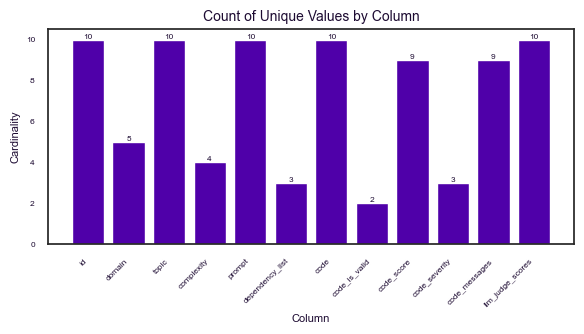

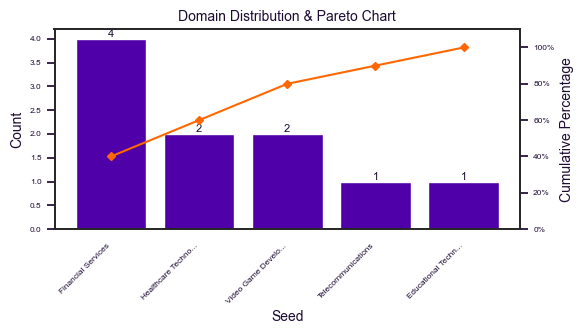

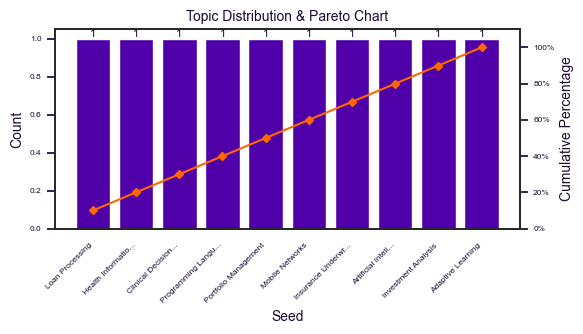

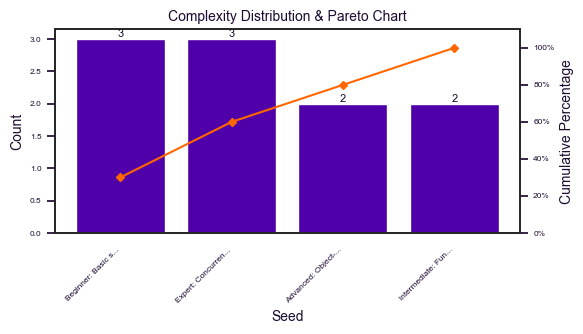

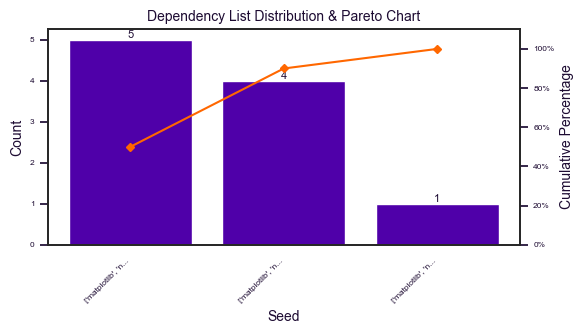

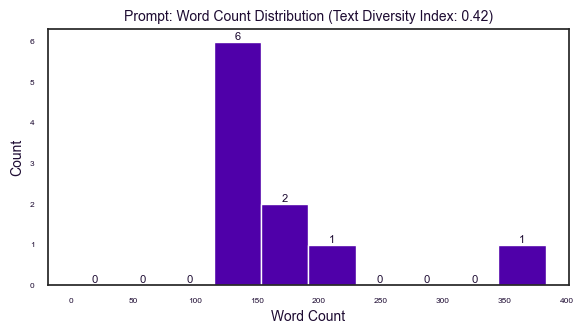

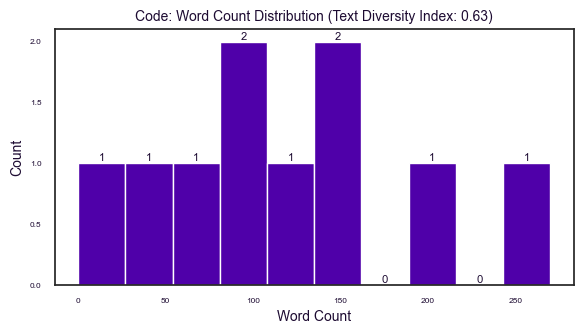

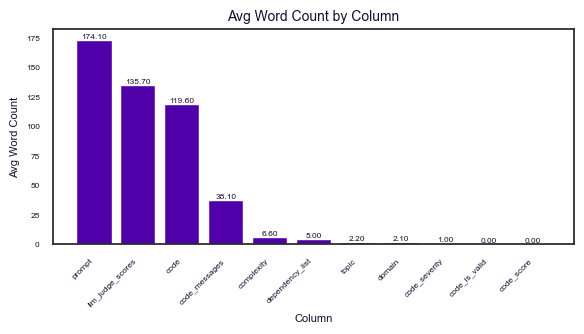

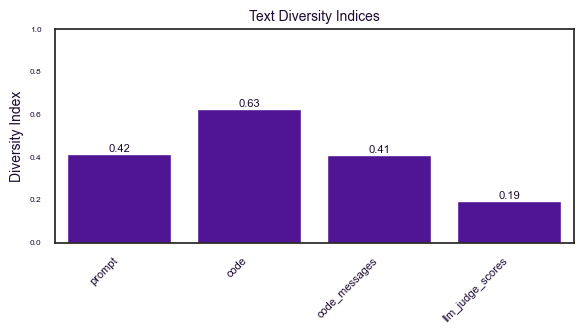

In [12]:
generate_and_save_pdf(results, 'data_quality_report.pdf')